# notebooks/pulse\_score.ipynb

**Overview**
This notebook ingests Buffalo raw data from Athena, spatially joins to 2020 Census tracts, computes tract-level metrics (crime, vacancy, permits, licences, 311), derives a composite score, and stores results for visualization and LLM narration.

---

## 1. Setup & Imports


In [1]:
import json
import os
import numpy as np
import awswrangler as wr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely.geometry as geom
from sklearn.metrics import root_mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap

/Users/colinspear/dev/civic-pulse-rochester/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Configure AWS:


In [2]:
os.environ['AWS_REGION'] = 'us-east-1'
wr.config.athena_workgroup = 'primary'
DATABASE = 'civic_pulse'


---

## 2. Load Raw Tables from Athena


In [3]:
# helper: read partition for a specific date
def read_last_n_event_days(table, ts_col, n=7):
    return wr.athena.read_sql_query(
        f"""
        SELECT DISTINCT *
        FROM {DATABASE}.{table}
        WHERE {ts_col} >= date_add('day', -{n}, current_timestamp)
        """,
        database=DATABASE
    )

HIST_DAYS = 365
INDEX_DAYS = 30

cut_hist   = pd.Timestamp.utcnow() - pd.Timedelta(days=HIST_DAYS)
cut_index  = pd.Timestamp.utcnow() - pd.Timedelta(days=INDEX_DAYS)

crime_df = read_last_n_event_days("raw_buf_crime",  "incident_datetime", HIST_DAYS)
viol_df  = read_last_n_event_days("raw_buf_viol",   "date",              HIST_DAYS)
perm_df  = read_last_n_event_days("raw_buf_permits","issued",            HIST_DAYS)
biz_df   = read_last_n_event_days("raw_buf_biz",    "issdttm",           HIST_DAYS)
calls_df = read_last_n_event_days("raw_buf_311",    "createddate",       HIST_DAYS)
    
crime_df["incident_datetime"] = pd.to_datetime(crime_df["incident_datetime"], utc=True).dt.tz_localize(None)
viol_df["date"] = pd.to_datetime(viol_df["date"], utc=True).dt.tz_localize(None)
perm_df["issued"] = pd.to_datetime(perm_df["issued"], utc=True).dt.tz_localize(None)
biz_df["issdttm"] = pd.to_datetime(biz_df["issdttm"], utc=True).dt.tz_localize(None)
calls_df["createddate"] = pd.to_datetime(calls_df["createddate"], utc=True).dt.tz_localize(None)


In [4]:
crime_df.describe()

,incident_datetime,latitude,longitude,pulled_utc
count,477156,445525.000000,445525.000000,477156
mean,2025-03-13 05:33:31.856738560,42.911927,-78.853181,2025-05-12 21:20:12.921588992
min,2024-11-14 00:01:00,42.634000,-79.028000,2025-05-12 21:03:38.803000
25%,2025-02-12 05:55:00,42.893000,-78.878000,2025-05-12 21:14:53.848000
50%,2025-03-21 11:45:54,42.913000,-78.855000,2025-05-12 21:20:33.836000
75%,2025-04-17 21:00:00,42.938000,-78.825000,2025-05-12 21:26:35.903000064
max,2025-05-11 10:48:42,43.016000,-78.670000,2025-05-12 21:30:07.023000
std,NaN,0.029636,0.030810,NaN



---

## 3. Load 2020 Tract Shapefile


In [5]:
# NY State tracts (state FIPS 36) from TIGER 2024
url = ("https://www2.census.gov/geo/tiger/TIGER2024/TRACT/"
       "tl_2024_36_tract.zip")

tracts = gpd.read_file(url)[["GEOID", "geometry"]].to_crs(epsg=4326)
tracts = tracts[tracts["GEOID"].str.startswith("36029")].copy()

In [6]:
path = "../data/acs2023_erie_tract_pop.json"   # adjust as needed

with open(path) as f:
    rows = json.load(f)        # rows[0] = header list, rows[1:] = data

header, data = rows[0], rows[1:]
acs = pd.DataFrame(data, columns=header)

# numeric casts
acs["population"]     = pd.to_numeric(acs["B02001_001E"], errors="coerce")
acs["housing_units"]  = pd.to_numeric(acs["B25001_001E"], errors="coerce")

# 11-digit GEOID
acs["GEOID"] = (
    acs["state"].str.zfill(2) +
    acs["county"].str.zfill(3) +
    acs["tract"].str.zfill(6)
)

acs = acs[["GEOID", "population", "housing_units"]]

tracts = tracts.merge(acs, on="GEOID", how="left")

---

## 4. Spatial Join Points → Tracts


In [7]:
# TODO: Add geocoder to extract lat/lon from addresses in permitting data
# import requests, pandas as pd, time, json

# def geocode_census(addr_series, batch=100):
#     out = {}
#     for chunk in addr_series.groupby(addr_series.index // batch):
#         payload = "\n".join(chunk[1].tolist())
#         resp = requests.post(
#             "https://geocoding.geo.census.gov/geocoder/geographies/addressbatch",
#             files={"addressFile": ("addrs.txt", payload),
#                    "benchmark": (None, "Public_AR_Current"),
#                    "vintage": (None, "Current_Current")}
#         )
#         for line in resp.text.strip().split("\n"):
#             parts = line.split(",")
#             if len(parts) >= 9 and parts[8]:
#                 out[parts[0]] = parts[8].zfill(11)   # tract GEOID
#         time.sleep(0.2)   # stay polite
#     return pd.Series(out, name="tract")

# perm_df["uid"] = perm_df.index.astype(str)  # unique row key for batch file
# perm_df["tract"] = geocode_census(perm_df["address"])

def join_points(df, lon='longitude', lat='latitude'):
    """
    If lon/lat columns are present, spatially join to tracts.
    Otherwise just add a null 'tract' column and return the original df.
    """
    if lon in df.columns and lat in df.columns:
        gdf = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df[lon], df[lat]),
            crs='EPSG:4326'
        )
        out = gpd.sjoin(gdf, tracts[['GEOID', 'geometry']],
                        how='left', predicate='within')
        return out.drop(columns='geometry').rename(columns={'GEOID': 'tract'})
    else:
        df = df.copy()
        df['tract'] = pd.NA
        return df

crime_gdf = join_points(crime_df)
viol_gdf  = join_points(viol_df)
perm_gdf  = join_points(perm_df, lon=None, lat=None)  # if no coords
biz_gdf   = join_points(biz_df)
calls_gdf = join_points(calls_df)


---

## 5. Compute Tract-Level Metrics


In [9]:
crime_recent = crime_gdf[crime_gdf["incident_datetime"] >= cut_index.tz_localize(None)]
viol_recent  = viol_gdf [viol_gdf ["date"]              >= cut_index.tz_localize(None)]
perm_recent  = perm_gdf [perm_gdf ["issued"]            >= cut_index.tz_localize(None)]
biz_recent   = biz_gdf  [biz_gdf  ["issdttm"]           >= cut_index.tz_localize(None)]
calls_recent = calls_gdf[calls_gdf["createddate"]       >= cut_index.tz_localize(None)]

# initialise metrics with all tracts
metrics = pd.DataFrame({
    "tract": tracts["GEOID"],
    "population": tracts["population"],
    "housing_units": tracts["housing_units"]
})


In [10]:

# 5.1 crime per 1 000 residents
crime_counts = crime_recent.groupby("tract").size().rename("crime_count")
metrics = metrics.merge(crime_counts, left_on="tract", right_index=True, how="left").fillna(0)

metrics["crime_per_1k"] = metrics["crime_count"] / (metrics["population"] / 1000).replace({0: pd.NA})

# 5.2 vacancy violations
viol_counts = viol_recent.groupby("tract").size().rename("vacant_code_count")
metrics = metrics.merge(viol_counts, left_on="tract", right_index=True, how="left").fillna(0)

# 5.3 permits (until geocoded, these stay NaN -> will be ignored in z-scores)
perm_counts = perm_recent.groupby("tract").size().rename("permit_count")
metrics = metrics.merge(perm_counts, left_on="tract", right_index=True, how="left").fillna(0)

# 5.4 business licences
biz_counts = biz_recent.groupby("tract").size().rename("licence_count")
metrics = metrics.merge(biz_counts, left_on="tract", right_index=True, how="left").fillna(0)

# 5.5 311 calls
call_counts = calls_recent.groupby("tract").size().rename("calls_count")
metrics = metrics.merge(call_counts, left_on="tract", right_index=True, how="left").fillna(0)


/var/folders/tj/2zm1pzk90t177_g7ndj99_y00000gn/T/ipykernel_16789/2736181212.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metrics = metrics.merge(viol_counts, left_on="tract", right_index=True, how="left").fillna(0)


---

## 6. Clean and calculate z-scores

In [11]:
features = ['crime_per_1k','vacant_code_count','permit_count','licence_count','calls_count']

# 0. ensure numeric, replace NaN, drop zero-variance cols
# Permits are zero variance until geocoded because metrics is tract-indexed
metrics[features] = metrics[features].fillna(0)
features = [f for f in features if metrics[f].std() > 0]


In [12]:

# 1. z-score each feature then sum
scaler = StandardScaler()
metrics[features] = scaler.fit_transform(metrics[features])
metrics["score"]  = metrics[features].sum(axis=1)


---
## 7. Build weekly dataset

In [13]:
# --------------------------------------------------
# 1. Harmonise datetime columns
# --------------------------------------------------
crime_gdf["incident_datetime"] = pd.to_datetime(crime_gdf["incident_datetime"], utc=True).dt.tz_localize(None)
viol_gdf["date"]               = pd.to_datetime(viol_gdf["date"])
perm_gdf["issued"]             = pd.to_datetime(perm_gdf["issued"])
biz_gdf["issdttm"]             = pd.to_datetime(biz_gdf["issdttm"], utc=True).dt.tz_localize(None)
calls_gdf["createddate"]       = pd.to_datetime(calls_gdf["createddate"], utc=True).dt.tz_localize(None)

# --------------------------------------------------
# 2. Add a uniform week key on every feed
# --------------------------------------------------
for gdf, col in [
    (crime_gdf, "incident_datetime"),
    (viol_gdf,  "date"),
    (perm_gdf,  "issued"),
    (biz_gdf,   "issdttm"),
    (calls_gdf, "createddate"),
]:
    gdf["week"] = gdf[col].dt.to_period("W-SUN").dt.start_time


In [14]:

# --------------------------------------------------
# 3. Build target (next-week 311 volume)  >>> weekly_y
# --------------------------------------------------
calls_gdf["week"] = calls_gdf["createddate"].dt.to_period("W-SUN").dt.start_time

weekly_y = (
    calls_gdf.groupby(["tract","week"]).size()
             .rename("calls_count")
             .reset_index()
)
weekly_y["target_week"] = weekly_y["week"] - pd.Timedelta(weeks=1)   # week t holds calls for t+1
weekly_y = weekly_y.rename(columns={"calls_count":"calls_next_week"})


In [15]:

# --------------------------------------------------
# 4. Build predictor table (weekly counts) >>> weekly_pred
# --------------------------------------------------
def weekly_counts(df, name):
    return (df.groupby(["tract","week"]).size()
              .rename(name).reset_index())

weekly_pred = (
    weekly_counts(crime_gdf, "crime_count")
      .merge(weekly_counts(viol_gdf,  "vacant_code_count"), on=["tract","week"], how="outer")
      .merge(weekly_counts(perm_gdf,  "permit_count"),      on=["tract","week"], how="outer")
      .merge(weekly_counts(biz_gdf,   "licence_count"),     on=["tract","week"], how="outer")
      .fillna(0)
)

# per-capita scaling
# initialise metrics with all tracts
all_tracts = pd.DataFrame({
    "tract": tracts["GEOID"],
    "population": tracts["population"],
})

weekly_pred = weekly_pred.merge(
    all_tracts, on="tract", how="left"
)
weekly_pred["crime_per_1k"] = weekly_pred["crime_count"] / (weekly_pred["population"]/1000)

feature_cols = ["crime_per_1k","vacant_code_count","permit_count","licence_count"]


In [54]:

# --------------------------------------------------
# 5. Merge predictors + target  >>> weekly_full
# --------------------------------------------------
weekly_full = weekly_pred.merge(
    weekly_y,
    left_on=["tract","week"],
    right_on=["tract","target_week"],
    how="inner"
).drop(columns="target_week")


In [55]:
weekly_full.head()

,tract,week_x,crime_count,vacant_code_count,permit_count,licence_count,population,crime_per_1k,week_y,calls_next_week
0,36029000110,2024-11-11,5.0,0.0,0.0,0.0,2631,1.900418,2024-11-18,114
1,36029000110,2024-11-18,24.0,0.0,0.0,0.0,2631,9.122007,2024-11-25,242
2,36029000110,2024-11-25,29.0,0.0,0.0,0.0,2631,11.022425,2024-12-02,474
3,36029000110,2024-12-02,19.0,0.0,0.0,0.0,2631,7.221589,2024-12-09,280
4,36029000110,2024-12-09,32.0,0.0,0.0,0.0,2631,12.162676,2024-12-16,490


In [56]:

weekly_full['week'] = weekly_full['week_x']
weekly_full = weekly_full.drop(['week_x', 'week_y'], axis=1)

# --------------------------------------------------
# 6. Transform, Train/test split, model, SHAP
# --------------------------------------------------
weekly_full = weekly_full.copy()
weekly_full["vacant_any"] = (weekly_full["vacant_code_count"] > 0).astype(int)
weekly_full["vacant_log"] = np.log1p(weekly_full["vacant_code_count"])
weekly_full["permit_log"] = np.log1p(weekly_full["permit_count"])
weekly_full["crime_log"]  = np.log1p(weekly_full["crime_per_1k"])

# removed vacant_any
feature_cols = ["crime_log","vacant_log","permit_log","licence_count"]
weekly_full[feature_cols] = weekly_full[feature_cols].fillna(0)

cutoff = weekly_full["week"].max() - pd.Timedelta(weeks=4)
train  = weekly_full[weekly_full.week < cutoff].set_index(["tract","week"])
test   = weekly_full[weekly_full.week >= cutoff].set_index(["tract","week"])

X_train, y_train = train[feature_cols], train["calls_next_week"]
X_test,  y_test  = test[feature_cols],  test["calls_next_week"]


---

## 8. XGBoost & SHAP

In [57]:
model = xgb.XGBRegressor(n_estimators=100, max_depth=3,
                         learning_rate=0.1, objective="reg:squarederror")
model.fit(X_train.values, y_train.values)

explainer   = shap.Explainer(model, X_train.values, feature_names=feature_cols)
shap_values = explainer(X_test.values)   # additivity check passes

print("Pipeline completed – SHAP shape:", shap_values.shape)


Pipeline completed – SHAP shape: (306, 4)


---

## 9. Sanity-check suite for Civic-Pulse GBM + SHAP


In [58]:
results = {}

# 2. Target variance -----------------------------------------------
results["var_train"] = y_train.var()
results["var_test"]  = y_test.var()
print("Target variance – train:", results["var_train"], "test:", results["var_test"])


Target variance – train: 1222707.0186199974 test: 2853108.058973535


In [59]:
# 3. Baseline vs. model RMSE ---------------------------------------
dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)
rmse_dummy = root_mean_squared_error(y_test, dummy.predict(X_test))
rmse_xgb   = root_mean_squared_error(y_test,  model.predict(X_test))
results["rmse_baseline"] = rmse_dummy
results["rmse_xgb"]      = rmse_xgb
print("RMSE  baseline:", rmse_dummy, "  XGB:", rmse_xgb,
      "\n(Expect XGB at least ~10 % lower)")


RMSE  baseline: 2312.4487381191034   XGB: 2087.925537109375 
(Expect XGB at least ~10 % lower)


([<matplotlib.axis.YTick at 0x1de79e100>,
 [Text(0, 0, 'crime_log'),
  Text(0, 1, 'vacant_log'),
  Text(0, 2, 'permit_log'),
  Text(0, 3, 'licence_count')])

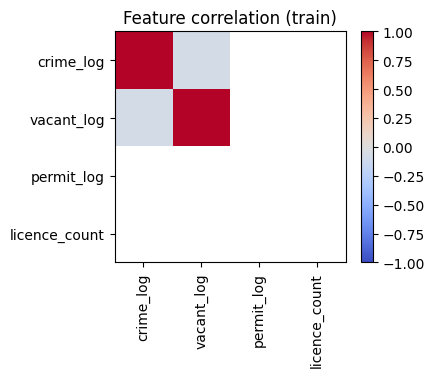

In [60]:

# 4. Feature correlation heat-map ----------------------------------
corr = pd.DataFrame(X_train, columns=feature_cols).corr()
plt.figure(figsize=(4,3)); plt.title("Feature correlation (train)")
plt.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm"); plt.colorbar()
plt.xticks(range(len(feature_cols)),feature_cols,rotation=90); plt.yticks(range(len(feature_cols)),feature_cols)
# Eyeball: any cell >|0.95| → drop one of the twins.


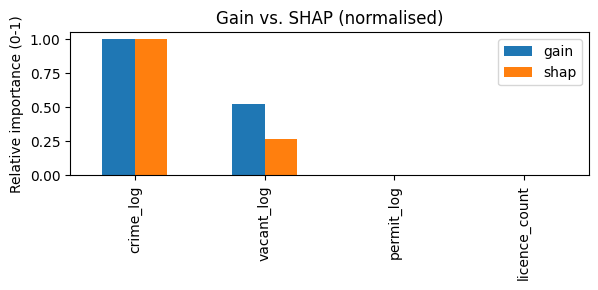

In [61]:
# 5. Gain vs. SHAP ranking -----------------------------------------
booster   = model.get_booster()
gain_dict = booster.get_score(importance_type='gain')

# map f0, f1, … to column names in feature_cols
gain_vec  = np.array([gain_dict.get(f"f{i}", 0) for i in range(len(feature_cols))])
shap_mean = np.abs(shap_values.values).mean(axis=0)

norm = lambda x: x / x.max() if x.max() else x
df_norm = pd.DataFrame({"gain": norm(gain_vec), "shap": norm(shap_mean)},
                       index=feature_cols).sort_values("shap", ascending=False)
df_norm.plot.bar(figsize=(6,3))
plt.ylabel("Relative importance (0-1)")
plt.title("Gain vs. SHAP (normalised)")
plt.tight_layout()


In [62]:

# 6. Additivity already checked by SHAP call -----------------------
print("SHAP additivity check passed earlier ✔")


SHAP additivity check passed earlier ✔


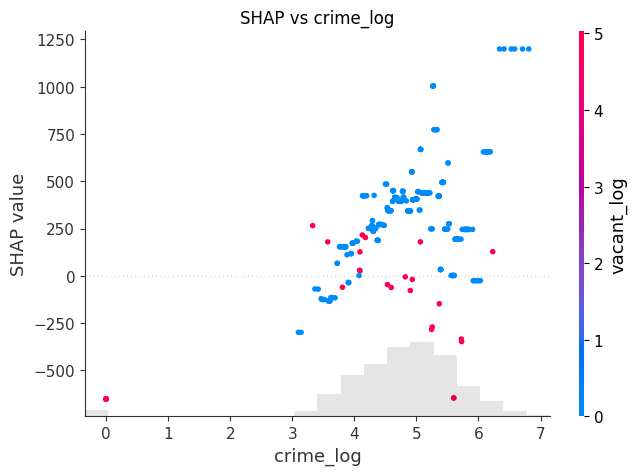

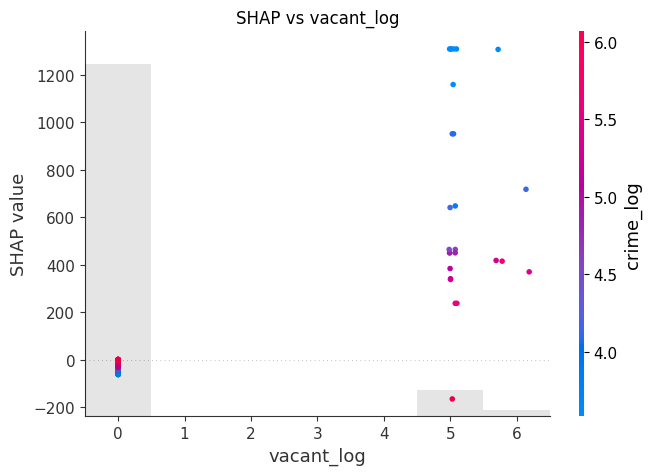

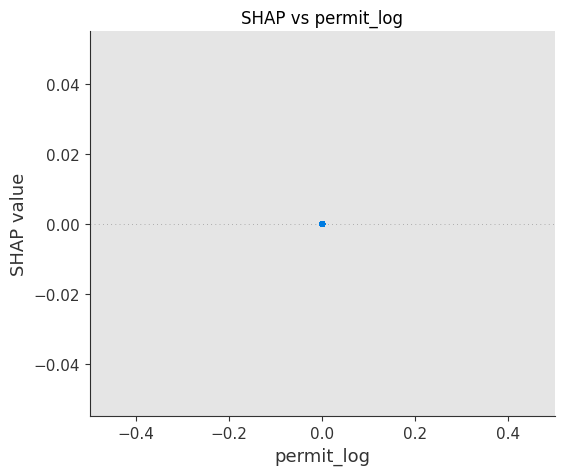

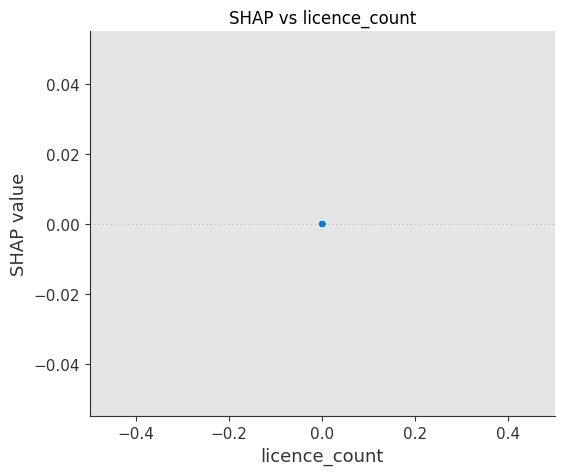

In [63]:

# 7. Direction sanity (scatter) ------------------------------------
for feat in feature_cols:
    disp = shap.plots.scatter(
        shap_values[:, feature_cols.index(feat)],
        color=shap_values,
        show=False
    )
    plt.title(f"SHAP vs {feat}")
    plt.xlabel(feat); plt.ylabel("SHAP value")
    plt.show()
    # Eyeball: monotone trend (upwards for risk-raising features).
    # U-shapes or clouds → clipping / transformation needed.


In [67]:

# 8. Stability across cut-offs ------------------------------------
from scipy.stats import spearmanr

# baseline ranking: mean(|SHAP|) on the main test set
rank0 = pd.Series(np.abs(shap_values.values).mean(0),
                  index=feature_cols).rank()

cutoff_max = weekly_full["week"].max()

for w in range(2, 6):      # 2- to 5-week hold-out slices
    cut = cutoff_max - pd.Timedelta(weeks=w)
    subset = weekly_full[weekly_full.week >= cut][feature_cols]

    if subset.empty:
        continue           # nothing to compare

    shap_subset = explainer(subset.values, check_additivity=False)
    rank_w = pd.Series(np.abs(shap_subset.values).mean(0),
                       index=feature_cols).rank()

    rho = spearmanr(rank0, rank_w).correlation
    print(f"Rank corr vs. {w:>2}-week window: {rho:.2f}  (expect ≥ 0.70)")


Rank corr vs.  2-week window: 1.00  (expect ≥ 0.70)
Rank corr vs.  3-week window: 1.00  (expect ≥ 0.70)
Rank corr vs.  4-week window: 1.00  (expect ≥ 0.70)
Rank corr vs.  5-week window: 1.00  (expect ≥ 0.70)


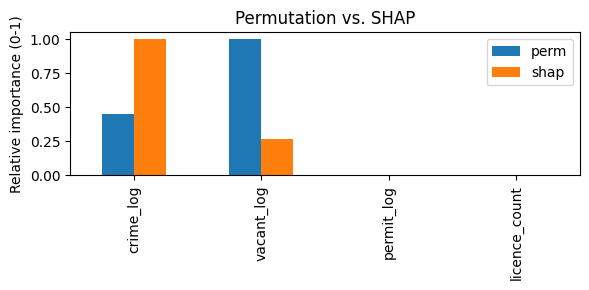

In [70]:

# 9. Permutation importance ----------------------------------------
perm = permutation_importance(model, X_test, y_test, n_repeats=30,
                              random_state=0)
perm_imp = pd.Series(perm.importances_mean, index=feature_cols)

norm = lambda x: x / x.max() if x.max() else x

df_norm = pd.DataFrame({"perm": norm(perm_imp), "shap": norm(shap_mean)},
                       index=feature_cols).sort_values("shap", ascending=False)

df_norm.plot.bar(figsize=(6,3))
plt.ylabel("Relative importance (0-1)")
plt.title("Permutation vs. SHAP"); plt.tight_layout()
plt.tight_layout()
# Eyeball: top few features align ≈; divergence → investigate.



Finished sanity checks – see plots & prints above.


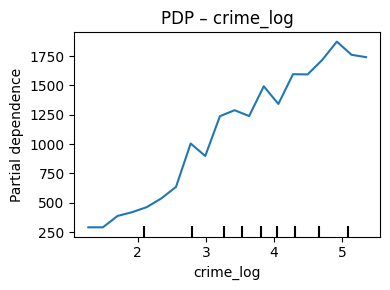

In [71]:

# 10. Partial-dependence sanity ------------------------------------
fig, ax = plt.subplots(figsize=(4,3))
PartialDependenceDisplay.from_estimator(model, X_train, [feature_cols[0]],
                                        grid_resolution=20, ax=ax)
plt.title(f"PDP – {feature_cols[0]}"); plt.tight_layout()
# Eyeball: curve should rise logically (e.g., more crime → more 311).

print("\nFinished sanity checks – see plots & prints above.")


---

## 8. Save Results to S3

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq
import boto3

metrics['run_date'] = pd.Timestamp.utcnow()

# write Parquet locally or to S3
table = pa.Table.from_pandas(metrics)
buf = pa.BufferOutputStream()
pq.write_table(table, buf, compression='zstd')
key = f"analytics/buf_pulse_score/{y}/{m}/{d}/pulse_score.parquet"

boto3.client('s3').put_object(
    Bucket=os.getenv('BUCKET'),
    Key=key,
    Body=buf.getvalue().to_pybytes()
)
print("Wrote composite metrics → s3://{}/{}".format(os.getenv('BUCKET'),key))



---

*Next:* Fill in ACS population load, training data for SHAP, and refine model fitting.
